In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
 import nltk
 nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
import pandas as pd
import numpy as np
from keras.preprocessing.text import Tokenizer,  text_to_word_sequence
from keras.engine.topology import Layer
from keras import initializers as initializers, regularizers, constraints
from keras.callbacks import Callback, ModelCheckpoint
from keras.utils.np_utils import to_categorical
from keras.layers import Embedding, Input, Dense, LSTM, GRU, Bidirectional, TimeDistributed, Dropout
from keras import backend as K
from keras import optimizers
from keras.models import Model
import nltk
import re
import matplotlib.pyplot as plt
import sys
from sklearn.metrics import roc_auc_score
from nltk import tokenize
import seaborn as sns
from sklearn.utils import shuffle


Using TensorFlow backend.


In [0]:
def dot_product(x, kernel):
    """
    Wrapper for dot product operation, in order to be compatibl|e with both
    Theano and Tensorflow
    Args:
        x (): input
        kernel (): weights
    Returns:
    """
    if K.backend() == 'tensorflow':
        return K.squeeze(K.dot(x, K.expand_dims(kernel)), axis=-1)
    else:
        return K.dot(x, kernel)

class AttentionWithContext(Layer):
    """
    Attention operation, with a context/query vector, for temporal data.
    Supports Masking.
    Follows the work of Yang et al. [https://www.cs.cmu.edu/~diyiy/docs/naacl16.pdf]
    "Hierarchical Attention Networks for Document Classification"
    by using a context vector to assist the attention
    # Input shape
        3D tensor with shape: `(samples, steps, features)`.
    # Output shape
        2D tensor with shape: `(samples, features)`.
    How to use:
    Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
    The dimensions are inferred based on the output shape of the RNN.
    Note: The layer has been tested with Keras 2.0.6
    Example:
        model.add(LSTM(64, return_sequences=True))
        model.add(AttentionWithContext())
        # next add a Dense layer (for classification/regression) or whatever...
    """

    def __init__(self,
                 W_regularizer=None, u_regularizer=None, b_regularizer=None,
                 W_constraint=None, u_constraint=None, b_constraint=None,
                 bias=True, **kwargs):

        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.u_regularizer = regularizers.get(u_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.u_constraint = constraints.get(u_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        super(AttentionWithContext, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1], input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        if self.bias:
            self.b = self.add_weight((input_shape[-1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)

        self.u = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_u'.format(self.name),
                                 regularizer=self.u_regularizer,
                                 constraint=self.u_constraint)

        super(AttentionWithContext, self).build(input_shape)

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None

    def call(self, x, mask=None):
        uit = dot_product(x, self.W)

        if self.bias:
            uit += self.b

        uit = K.tanh(uit)
        ait = dot_product(uit, self.u)

        a = K.exp(ait)

        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= K.cast(mask, K.floatx())

        # in some cases especially in the early stages of training the sum may be almost zero
        # and this results in NaN's. A workaround is to add a very small positive number ε to the sum.
        # a /= K.cast(K.sum(a, axis=1, keepdims=True), K.floatx())
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[-1]

In [5]:
 data_frame = shuffle(pd.read_csv('drive/My Drive/Colab Notebooks/dataset/yelp2014train.ss',sep='\t\t', names=["user", "business(product)", "rating", "review"])).reset_index()
data_frame = data_frame[0:60000]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


In [0]:
df = data_frame[['review', 'rating']]
rating = df['rating']
review = df['review']

In [7]:
cates = df.groupby('rating')
print("total categories:", cates.ngroups)
print(cates.size())

total categories: 5
rating
1     2365
2     5307
3    11954
4    23784
5    16590
dtype: int64


In [0]:
import re
def clean_str(string):
    """
    Tokenization/string cleaning for dataset
    Every dataset is lower cased except
    """
    string = re.sub(r"\\", "", string)    
    string = re.sub(r"\'", "", string)    
    string = re.sub(r"\"", "", string)    
    return string.strip().lower()

In [0]:
paras = []
labels = []
texts = []
sentence_lens = []
sentence_nums = []
for idx in range(df.review.shape[0]):
    text = clean_str(df.review[idx])
    texts.append(text)
    sentences = tokenize.sent_tokenize(text)
    sentence_nums.append(len(sentences))
    for sent in sentences:
        sentence_lens.append(len(text_to_word_sequence(sent)))
    paras.append(sentences)

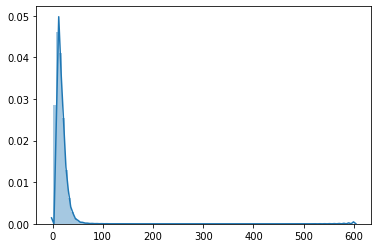

In [10]:
sns.distplot(sentence_lens, bins=100)
plt.show()

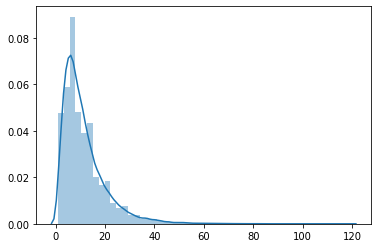

In [11]:
sns.distplot(sentence_nums)
plt.show()

In [0]:
max_features=200000
max_senten_len=40
max_senten_num=6
embed_size=100
VALIDATION_SPLIT = 0.2

In [0]:
tokenizer = Tokenizer(num_words=max_features, oov_token=True)
tokenizer.fit_on_texts(texts)

In [0]:
data = np.zeros((len(texts), max_senten_num, max_senten_len), dtype='int32')
for i, sentences in enumerate(paras):
    for j, sent in enumerate(sentences):
        if j< max_senten_num:
            wordTokens = text_to_word_sequence(sent)
            k=0
            for _, word in enumerate(wordTokens):
                try:
                    if k<max_senten_len and tokenizer.word_index[word]<max_features:
                        data[i,j,k] = tokenizer.word_index[word]
                        k=k+1
                except:
                    print(word)
                    pass

In [15]:
data.shape

(60000, 6, 40)

In [16]:
word_index = tokenizer.word_index
print('Total %s unique tokens.' % len(word_index))

Total 67951 unique tokens.


In [0]:
labels = pd.get_dummies(rating)

In [18]:
labels.shape

(60000, 5)

In [19]:
print('Shape of data tensor:', data.shape)
print('Shape of labels tensor:', labels.shape)

Shape of data tensor: (60000, 6, 40)
Shape of labels tensor: (60000, 5)


In [20]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels.iloc[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]
print('Number of positive and negative reviews in traing and validation set')
print(y_train.columns.tolist())
print(y_train.sum(axis=0).tolist())
print(y_val.sum(axis=0).tolist())

Number of positive and negative reviews in traing and validation set
[1, 2, 3, 4, 5]
[1892, 4242, 9559, 19063, 13244]
[473, 1065, 2395, 4721, 3346]


##Model

In [21]:
import os
GLOVE_DIR = "drive/My Drive/Colab Notebooks/dataset/glove.6B.100d.txt"
embeddings_index = {}
f = open(GLOVE_DIR)
for line in f:
    try:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    except:
        print(word)
        pass
f.close()
print('Total %s word vectors.' % len(embeddings_index))

Total 400000 word vectors.


In [22]:
embedding_matrix = np.zeros((len(word_index) + 1, embed_size))
absent_words = 0
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        absent_words += 1
print('Total absent words are', absent_words, 'which is', "%0.2f" % (absent_words * 100 / len(word_index)), '% of total words')

Total absent words are 21384 which is 31.47 % of total words


In [23]:
embedding_layer = Embedding(len(word_index) + 1,embed_size,weights=[embedding_matrix], input_length=max_senten_len, trainable=False)

In [24]:
from keras import regularizers
REG_PARAM = 4e-4
l2_reg = regularizers.l2(REG_PARAM)
word_input = Input(shape=(max_senten_len,), dtype='float32')
word_sequences = embedding_layer(word_input)
word_lstm = Bidirectional(LSTM(150, return_sequences=True, kernel_regularizer=l2_reg))(word_sequences)
word_dense = TimeDistributed(Dense(300, kernel_regularizer=l2_reg))(word_lstm)
word_att = AttentionWithContext()(word_dense)
wordEncoder = Model(word_input, word_att)

sent_input = Input(shape=(max_senten_num, max_senten_len), dtype='float32')
sent_encoder = TimeDistributed(wordEncoder)(sent_input)
sent_lstm = Bidirectional(LSTM(150, return_sequences=True, kernel_regularizer=l2_reg))(sent_encoder)
sent_dense = TimeDistributed(Dense(300, kernel_regularizer=l2_reg))(sent_lstm)
sent_att = Dropout(0.5)(AttentionWithContext()(sent_dense))
preds = Dense(5, activation='softmax')(sent_att)
model = Model(sent_input, preds)
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc'])










Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.




In [0]:
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint('drive/My Drive/Colab Notebooks/weights/HAN_model.h5', verbose=0, monitor='val_loss',save_best_only=True, mode='auto') 

In [26]:
# model.load_weights("drive/My Drive/Colab Notebooks/weights/HAN_model.h5")
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc'])
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=20, batch_size=512, callbacks=[checkpoint])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 48000 samples, validate on 12000 samples
Epoch 1/20
48000/48000 [==============================] - 28s 581us/step - loss: 1.6919 - acc: 0.4214 - val_loss: 1.4630 - val_acc: 0.4538
Epoch 2/20
48000/48000 [==============================] - 24s 502us/step - loss: 1.3704 - acc: 0.4769 - val_loss: 1.3152 - val_acc: 0.4891
Epoch 3/20
48000/48000 [==============================] - 24s 504us/step - loss: 1.2895 - acc: 0.4865 - val_loss: 1.2680 - val_acc: 0.4932
Epoch 4/20
48000/48000 [==============================] - 24s 502us/step - loss: 1.2355 - acc: 0.5001 - val_loss: 1.2386 - val_acc: 0.5021
Epoch 5/20
48000/48000 [==============================] - 24s 502us/step - loss: 1.2079 - acc: 0.5062 - val_loss: 1.2029 - val_acc: 0.5046
Epoch 6/20
48000/48000 [==============================] - 24s 503us/step - loss: 1.1785 - acc: 0.5090 - val_loss: 1.1754 - val_acc: 0.5167
Epoch 7/20
48000/480

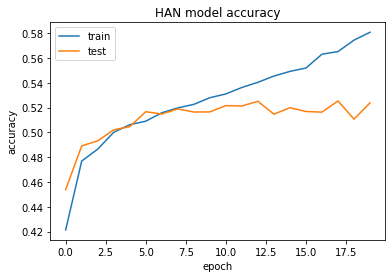

In [27]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('HAN model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

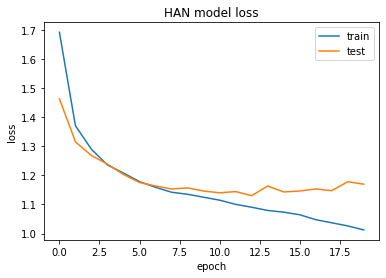

In [28]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('HAN model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [0]:
model.save('drive/My Drive/Colab Notebooks/model/HAN.h5')